In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install bert

In [ ]:
# !pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import DebertaConfig, DebertaModel
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    AutoConfig,
)

In [ ]:
from transformers import DebertaTokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
df = pd.read_csv ('/content/drive/MyDrive/new_llm/FinalADR.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df=df.dropna()
df.head()

,text,searchTerm,disease,processed_text
0,Buy top levothyroxine online on our free compa...,Levothyroxine,Cancer,"['buy', 'top', 'free', 'comparison', 'site', '..."
1,@femmebostonian @Cherrell_Brown This has been ...,Levothyroxine,Cancer,"['super', 'help', 'switch', 'due', 'cost', 'ne..."
2,For a decade I was on Levothyroxine 137 mcg. I...,Levothyroxine,Cancer,"['decad', 'see', 'even', 'bit', 'bad', 'heart'..."
3,@yourAAH Hi could you tell me which of your UK...,Levothyroxine,Cancer,"['hi', 'could', 'tell', 'stock']"
4,And my levothyroxine,Levothyroxine,Cancer,[]


In [ ]:
# from google.colab import sheets
# sheet = sheets.InteractiveSheet(df=side_effects_df)

MessageError: Error: credential propagation was unsuccessful

In [ ]:
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
import nltk
import re
import string
import pandas as pd
import numpy as np
from wordcloud import WordCloud
string.punctuation

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')

# Initialize stop words, English words corpus, and stemmer
stop_words = set(stopwords.words('english'))
english_words = set(words.words())
# stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the text column
df['Cleantext'] = df['text'].apply(preprocess)

In [ ]:
df.head()

,text,searchTerm,disease,processed_text,Cleantext
0,Buy top levothyroxine online on our free compa...,Levothyroxine,Cancer,"['buy', 'top', 'free', 'comparison', 'site', '...",buy top levothyroxine online on our free compa...
1,@femmebostonian @Cherrell_Brown This has been ...,Levothyroxine,Cancer,"['super', 'help', 'switch', 'due', 'cost', 'ne...",femmebostonian cherrellbrown this has been sup...
2,For a decade I was on Levothyroxine 137 mcg. I...,Levothyroxine,Cancer,"['decad', 'see', 'even', 'bit', 'bad', 'heart'...",for a decade i was on levothyroxine mcg i was...
3,@yourAAH Hi could you tell me which of your UK...,Levothyroxine,Cancer,"['hi', 'could', 'tell', 'stock']",youraah hi could you tell me which of your uk ...
4,And my levothyroxine,Levothyroxine,Cancer,[],and my levothyroxine


In [ ]:
df.disease.unique()

array(['Cancer', 'High_Bp', 'Diabetes'], dtype=object)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df['label']=encoder.fit_transform(df['disease'])
df.tail()

,text,searchTerm,disease,processed_text,Cleantext,label
3940,Rapid quantitation of atorvastatin in process ...,Atorvastatin,Diabetes,"['rapid', 'process', 'pharmaceut', 'powder', '...",rapid quantitation atorvastatin process pharma...,1
3941,Ice bucket challenge research results... chole...,Atorvastatin,Diabetes,"['ice', 'bucket', 'challeng', 'research', 'cho...",ice bucket challenge research results choleste...,1
3942,@Theironlady2017 What I've been doing is takin...,Atorvastatin,Diabetes,"['take', 'go', 'bed', 'spoke', 'doesnt', 'know...",theironlady ive taking ibuprofen go bed spoke ...,1
3943,@PaulLantos @ercowboy @MDaware @critconcepts @...,Atorvastatin,Diabetes,"['dogma', 'doctrin', 'taught', 'believ', 'fact...",paullantos ercowboy mdaware critconcepts markh...,1
3944,What happens when Atorvastatin is taken with g...,Atorvastatin,Diabetes,"['taken', 'grapefruit', 'juic']",happens atorvastatin taken grapefruit juice rx...,1


In [ ]:
df['text'][0]

'Buy top levothyroxine online on our free comparison site! BEST OFFER SUPER PRICES -Best Place To Compare Prices https://t.co/wAoqUl71is'

In [ ]:
# Verify label encoding
num_unique_labels = len(encoder.classes_)
print("Number of unique labels:", num_unique_labels)
assert num_unique_labels ==3, "The number of labels should be 3"

Number of unique labels: 3


In [ ]:
X=df.Cleantext
Y=df.label
# Initial split into train and temp (test + validation)
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.33, random_state=42)

# Further split temp into test and validation
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.225, random_state=42)

In [ ]:
X_train = X_train.tolist()
y_train = y_train.tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()
y_val=y_val.tolist()
X_val=X_val.tolist()

In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=170)
valid_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=170)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=170)

In [ ]:
id2label = {i: label for i, label in enumerate(['Cancer', 'High_Bp', 'Diabetes'])}

In [ ]:
config = AutoConfig.from_pretrained("roberta-base")
config.update({"id2label": id2label})

In [ ]:
class DATALOADER(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = DATALOADER(train_encodings, y_train)
valid_dataset = DATALOADER(valid_encodings, y_val)
test_dataset = DATALOADER(test_encodings, y_test)

In [ ]:
from transformers import AutoModelForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained("roberta-base", config=config)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [ ]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=20,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    logging_steps=400,
    save_steps=400,
    evaluation_strategy="steps",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import  Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
400,0.491900,0.177686,0.965870
800,0.122000,0.120568,0.972696
1200,0.085700,0.113146,0.972696
1600,0.079400,0.165194,0.965870
2000,0.058600,0.124897,0.979522
2400,0.045800,0.096671,0.982935
2800,0.018600,0.113904,0.976109
3200,0.017800,0.105484,0.982935


TrainOutput(global_step=3300, training_loss=0.11289649385394472, metrics={'train_runtime': 746.7659, 'train_samples_per_second': 35.312, 'train_steps_per_second': 4.419, 'total_flos': 1178969085580860.0, 'train_loss': 0.11289649385394472, 'epoch': 10.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.044639237225055695,
 'eval_accuracy': 0.9829351535836177,
 'eval_runtime': 1.645,
 'eval_samples_per_second': 178.11,
 'eval_steps_per_second': 9.118,
 'epoch': 10.0}

In [ ]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.06335519254207611,
 'eval_accuracy': 0.9860973187686196,
 'eval_runtime': 5.8131,
 'eval_samples_per_second': 173.229,
 'eval_steps_per_second': 8.773,
 'epoch': 10.0}

In [ ]:
eval_results =trainer.evaluate(test_dataset)

# Predict on the evaluation dataset to get logits
predictions = trainer.predict(test_dataset)

In [ ]:
import numpy as np

# Extract true labels
true_labels = predictions.label_ids

# Extract predicted labels (argmax over logits)
preds = np.argmax(predictions.predictions, axis=1)


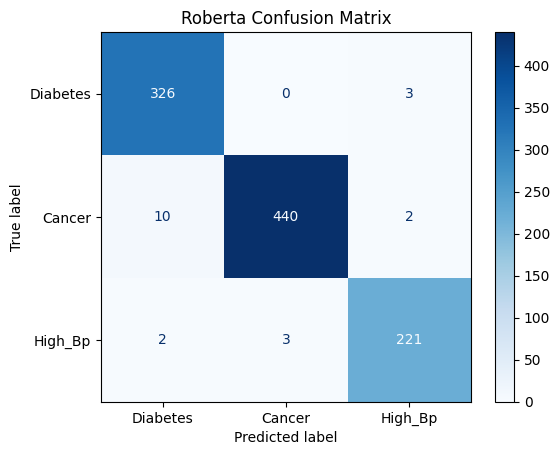

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = ['Diabetes', 'Cancer', 'High_Bp']

# Compute the confusion matrix
cm = confusion_matrix(true_labels, preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

plt.title('Roberta Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Assuming true_labels and preds are already defined
print(classification_report(true_labels, preds, target_names=labels))


              precision    recall  f1-score   support

    Diabetes       0.96      0.99      0.98       329
      Cancer       0.99      0.97      0.98       452
     High_Bp       0.98      0.98      0.98       226

    accuracy                           0.98      1007
   macro avg       0.98      0.98      0.98      1007
weighted avg       0.98      0.98      0.98      1007



In [ ]:
# saving the fine tuned model & tokenizer
model_path = "/content/drive/MyDrive/Roberta"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/Roberta/tokenizer_config.json',
 '/content/drive/MyDrive/Roberta/special_tokens_map.json',
 '/content/drive/MyDrive/Roberta/vocab.json',
 '/content/drive/MyDrive/Roberta/merges.txt',
 '/content/drive/MyDrive/Roberta/added_tokens.json',
 '/content/drive/MyDrive/Roberta/tokenizer.json')

In [ ]:
trainer.evaluate()

{'eval_loss': 0.07798875868320465,
 'eval_accuracy': 0.9846153846153847,
 'eval_runtime': 10.8344,
 'eval_samples_per_second': 119.989,
 'eval_steps_per_second': 5.999,
 'epoch': 10.0}

In [ ]:
# saving the fine tuned model & tokenizer
model_path = "/content/drive/MyDrive/LLMART/bert-base-cased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/LLMART/bert-base-cased/tokenizer_config.json',
 '/content/drive/MyDrive/LLMART/bert-base-cased/special_tokens_map.json',
 '/content/drive/MyDrive/LLMART/bert-base-cased/vocab.txt',
 '/content/drive/MyDrive/LLMART/bert-base-cased/added_tokens.json',
 '/content/drive/MyDrive/LLMART/bert-base-cased/tokenizer.json')

In [ ]:
def get_prediction(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=70 ,return_tensors="pt").to("cuda")
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    target_names=['Levothyroxine', 'revlimid', 'Rituxan', 'Herceptin', 'Avastin',
       'Losartan', 'Lisinopril', 'Amlodipine', 'Lasix', 'Carvedilol',
       'Humalog', 'Levemir', 'Lantus', 'Canagliflozin', 'Atorvastatin']
    return target_names[probs.argmax()]

In [ ]:
get_prediction('Buy top Levothyroxine online on our free comparison site! BEST OFFER SUPER PRICES -Best Place To Compare Prices')

'Levothyroxine'